In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

base_dir = "/content/drive/MyDrive/Face Shape Dataset"
train_dir = f"{base_dir}/training_set"
test_dir = f"{base_dir}/testing_set"

train_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


model = timm.create_model("efficientnet_b4", pretrained=True)

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes),
)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

print("Backbone frozen, classifier trainable")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)

epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_acc = correct / len(train_dataset)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.3f} | Accuracy: {train_acc:.3f}")


model.eval()
correct = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        correct += (outputs.argmax(dim=1) == labels).sum().item()

test_acc = correct / len(test_dataset)
print("\nFINAL TEST ACCURACY:", test_acc)

torch.save(model.state_dict(), "face_shape_finetuned.pth")
print("Model saved!")


Classes: ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
Backbone frozen, classifier trainable
Epoch [1/15] | Loss: 399.131 | Accuracy: 0.262
Epoch [2/15] | Loss: 390.473 | Accuracy: 0.366
Epoch [3/15] | Loss: 384.052 | Accuracy: 0.398
Epoch [4/15] | Loss: 377.891 | Accuracy: 0.416
Epoch [5/15] | Loss: 372.210 | Accuracy: 0.423
Epoch [6/15] | Loss: 367.510 | Accuracy: 0.431
Epoch [7/15] | Loss: 363.186 | Accuracy: 0.440
Epoch [8/15] | Loss: 359.205 | Accuracy: 0.453
Epoch [9/15] | Loss: 355.616 | Accuracy: 0.451
Epoch [10/15] | Loss: 352.330 | Accuracy: 0.452
Epoch [11/15] | Loss: 349.370 | Accuracy: 0.459
Epoch [12/15] | Loss: 347.494 | Accuracy: 0.462
Epoch [13/15] | Loss: 344.160 | Accuracy: 0.464
Epoch [14/15] | Loss: 342.627 | Accuracy: 0.461
Epoch [15/15] | Loss: 341.380 | Accuracy: 0.464

FINAL TEST ACCURACY: 0.442
Model saved!


In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

base_dir = "/content/drive/MyDrive/Face Shape Dataset"
train_dir = f"{base_dir}/training_set"
test_dir = f"{base_dir}/testing_set"

train_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.15, 0.15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)


model = timm.create_model("efficientnet_b4", pretrained=False)

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes),
)

model.load_state_dict(torch.load("face_shape_finetuned.pth"))

model = model.to(device)

print("Model loaded successfully! Ready for fine-tuning 🚀")


Model loaded successfully! Ready for fine-tuning 🚀


In [ ]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# **Best accuracy**

In [ ]:
for param in model.blocks[-2:].parameters():
    param.requires_grad = True

for param in model.bn2.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

criterion = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    acc = correct / len(train_dataset)

    print(f"[FineTune {epoch+1}/{epochs}] Loss: {total_loss:.3f} | Acc: {acc:.3f}")


model.eval()
correct = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        correct += (outputs.argmax(dim=1) == labels).sum().item()

test_acc = correct / len(test_dataset)

print("\n===== RESULT AFTER FINE-TUNING =====")
print("Test Accuracy:", test_acc)


torch.save(model.state_dict(), "face_shape_finetuned_v2.pth")
print("🔄 Model saved as face_shape_finetuned_v2.pth")


[FineTune 1/10] Loss: 327.261 | Acc: 0.481
[FineTune 2/10] Loss: 315.677 | Acc: 0.504
[FineTune 3/10] Loss: 303.469 | Acc: 0.523
[FineTune 4/10] Loss: 290.089 | Acc: 0.542
[FineTune 5/10] Loss: 279.240 | Acc: 0.565
[FineTune 6/10] Loss: 266.960 | Acc: 0.577
[FineTune 7/10] Loss: 260.194 | Acc: 0.594
[FineTune 8/10] Loss: 247.161 | Acc: 0.615
[FineTune 9/10] Loss: 234.143 | Acc: 0.639
[FineTune 10/10] Loss: 227.494 | Acc: 0.656

===== RESULT AFTER FINE-TUNING =====
Test Accuracy: 0.605
🔄 Model saved as face_shape_finetuned_v2.pth


In [ ]:
model.load_state_dict(torch.load("face_shape_finetuned_v2.pth"))


<All keys matched successfully>

# **Testing**

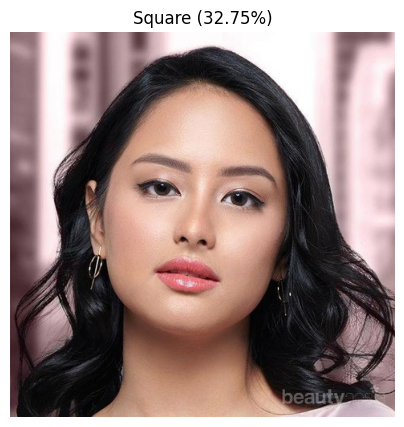

Predicted: Square
Confidence: 0.32753896713256836


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

classes = train_dataset.classes

def show_prediction(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = test_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(input_tensor)[0]

    idx = torch.argmax(pred).item()
    confidence = torch.softmax(pred, dim=0)[idx].item()

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{classes[idx]} ({confidence*100:.2f}%)")
    plt.show()

    return classes[idx], confidence


shape, conf = show_prediction("/content/test.jpeg")
print("Predicted:", shape)
print("Confidence:", conf)



# **Full Detail Train**

Classes: ['Heart', 'Oblong', 'Oval', 'Round', 'Square']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Backbone frozen, classifier trainable

===== STAGE 1: TRAIN CLASSIFIER ONLY =====
[Epoch 1/15] Train Loss=399.248 | Train Acc=0.262 | Val Loss=99.648 | Val Acc=0.335
[Epoch 2/15] Train Loss=390.910 | Train Acc=0.365 | Val Loss=97.811 | Val Acc=0.401
[Epoch 3/15] Train Loss=384.049 | Train Acc=0.400 | Val Loss=96.297 | Val Acc=0.419
[Epoch 4/15] Train Loss=377.738 | Train Acc=0.415 | Val Loss=94.961 | Val Acc=0.435
[Epoch 5/15] Train Loss=371.526 | Train Acc=0.429 | Val Loss=93.965 | Val Acc=0.441
[Epoch 6/15] Train Loss=367.682 | Train Acc=0.425 | Val Loss=92.778 | Val Acc=0.445
[Epoch 7/15] Train Loss=362.747 | Train Acc=0.441 | Val Loss=92.130 | Val Acc=0.446
[Epoch 8/15] Train Loss=358.348 | Train Acc=0.448 | Val Loss=91.170 | Val Acc=0.444
[Epoch 9/15] Train Loss=356.751 | Train Acc=0.444 | Val Loss=90.402 | Val Acc=0.444
[Epoch 10/15] Train Loss=352.948 | Train Acc=0.454 | Val Loss=89.747 | Val Acc=0.458
[Epoch 11/15] Train Loss=350.683 | Train Acc=0.456 | Val Loss=89.150 | Val Ac

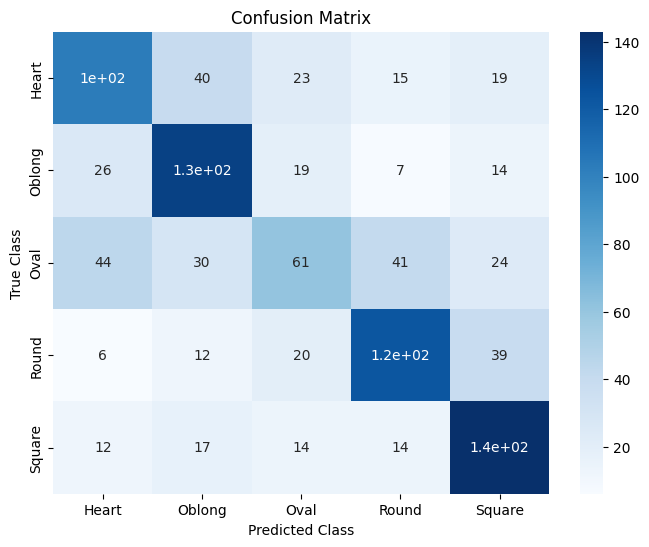

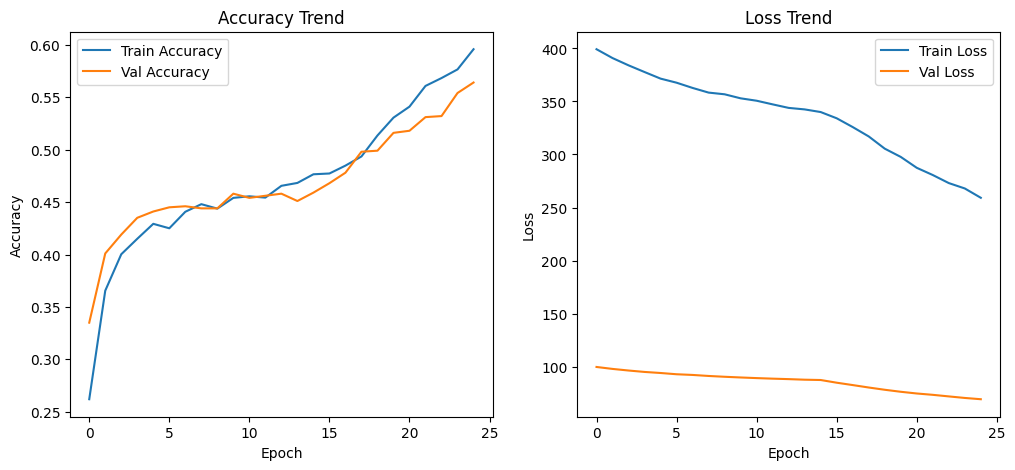

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from PIL import Image
from PIL import ImageFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

ImageFile.LOAD_TRUNCATED_IMAGES = True

base_dir = "/content/drive/MyDrive/Face Shape Dataset"
train_dir = f"{base_dir}/training_set"
test_dir = f"{base_dir}/testing_set"

train_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


model = timm.create_model("efficientnet_b4", pretrained=True)

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes),
)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

print("Backbone frozen, classifier trainable")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 15

print("\n===== STAGE 1: TRAIN CLASSIFIER ONLY =====")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)


    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss={total_loss:.3f} | Train Acc={train_acc:.3f} "
          f"| Val Loss={val_loss:.3f} | Val Acc={val_acc:.3f}")


torch.save(model.state_dict(), "face_shape_finetuned_stage1.pth")


print("\n===== STAGE 2: FINE TUNING BACKBONE =====")

for param in model.blocks[-2:].parameters():
    param.requires_grad = True

for param in model.bn2.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fine_epochs = 10
for epoch in range(fine_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)


    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[FineTune {epoch+1}/{fine_epochs}] Train Loss={total_loss:.3f} | Train Acc={train_acc:.3f} "
          f"| Val Loss={val_loss:.3f} | Val Acc={val_acc:.3f}")


torch.save(model.state_dict(), "face_shape_finetuned_v2.pth")

print("\n🔄 Model FINAL saved as face_shape_finetuned_v2.pth")


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


print("\n===== PER CLASS ACCURACY =====")
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

for i, cls in enumerate(train_dataset.classes):
    cls_idx = all_labels == i
    cls_correct = np.sum(all_preds[cls_idx] == i)
    cls_total = np.sum(cls_idx)
    cls_acc = cls_correct / cls_total
    print(f"{cls:10s} : {cls_acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Trend")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trend")
plt.legend()

plt.show()
